In [56]:
import pandas as pd #membaca data csv
import numpy as np

import matplotlib.pyplot as plt #menampilkan grafik
import seaborn as sns #menampilkan grafik

from sklearn.model_selection import train_test_split #memecah data untuk train dan test
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers

from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model #plot model

# DATASET

In [57]:
train = pd.read_csv('dataset/train.csv') #membaca dataset train dari mnist
test = pd.read_csv('dataset/test.csv') #membaca dataset test dari mnist
print("Data are Ready!!")

Data are Ready!!


In [58]:
print(f"Training data size adalah {train.shape}") #menampilkan size dari data train
print(f"Testing data size adalah {test.shape}") #menampilkan size data data test

Training data size adalah (42000, 785)
Testing data size adalah (28000, 784)


In [59]:
X = train.drop(['label'], 1).values #drop column label pada data train
y = train['label'].values

test_x = test.values

C:\Users\ASUS\.conda\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [60]:
X = X / 255.0
test_x = test_x / 255.0

In [61]:
# Reshape image 3 dimensi (height = 28px, width = 28px , canal = 1)
# canal = 1 => untuk gray scale
X = X.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)

In [62]:
# Encode labels menjadi one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y)

print(f"Label size {y.shape}")

Label size (42000, 10)


## Split training and valdiation set

In [63]:
# Split train dan validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [64]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape #melihat bentuk dari setiap variabel

((33600, 28, 28, 1), (8400, 28, 28, 1), (33600, 10), (8400, 10))

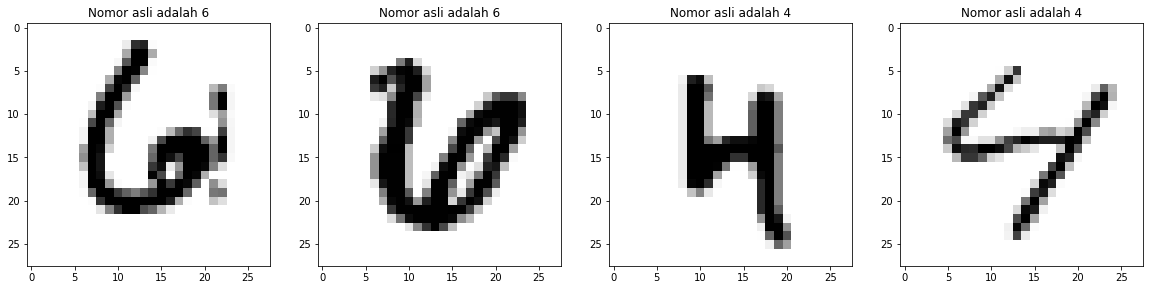

In [65]:
#reshape data x_train
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))

#menampilkan contoh data train
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Nomor asli adalah {digit}");

In [66]:
mean = np.mean(X_train) #mencari rata - rata
std = np.std(X_train)  #mencari simpanan baku

#membuat fungsi standarisasi
def standardize(x):
    return (x-mean)/std

In [67]:
batch_size = 64 #menset batchsize menjadi 64

## Model

In [68]:
#membuat model LSTM yang akan digunakan

model=Sequential()

model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1))) #menambahkan conv2d untuk menjalankan operasi konbolusional pada gambar
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2))) #untuk operasi poolingnya
model.add(BatchNormalization()) #untuk mengurangi pergeseran kovarian atau menyamakn distribusi setiap nilai input yang selalu berubah karena perubahan pada layer sebelumnya selama proses training

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    
model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
    
model.add(MaxPooling2D(pool_size=(2,2)))
    
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation="relu")) # untuk menambahkan layer yang fully connected
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [69]:
# Menggunakan augmentasi data untuk mencegah overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean ke 0 di atas dataset
        samplewise_center=False,  # set setiap mean sample ke 0
        featurewise_std_normalization=False,  # membagi input dengan std dari dataset
        samplewise_std_normalization=False,  # membagi setiap input dengan std nya
        zca_whitening=False,  # menerapkan ZCA whitening
        rotation_range=10,  # memutar gambar secara acak dalam rentang (derajat, 0 hingga 180)
        zoom_range = 0.1, # Perbesar gambar secara acak
        width_shift_range=0.1,  # menggeser gambar secara acak secara horizontal (fraksi dari total lebar)
        height_shift_range=0.1,  # menggeser gambar secara acak secara vertikal (fraksi dari tinggi total)
        horizontal_flip=False,  # membalik gambar secara acak
        vertical_flip=False)  # membalik gambar secara acak

train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
test_gen = datagen.flow(X_test, y_test, batch_size=batch_size)

### Model Training

In [70]:
# Fit modelnya
history = model.fit_generator(train_gen, 
                              epochs = 50, 
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = X_test.shape[0] // batch_size)

Epoch 1/50
525/525 [==============================] - 85s 160ms/step - loss: 0.3399 - accuracy: 0.8887 - val_loss: 0.1155 - val_accuracy: 0.9655
Epoch 2/50
525/525 [==============================] - 82s 157ms/step - loss: 0.0710 - accuracy: 0.9771 - val_loss: 0.0715 - val_accuracy: 0.9791
Epoch 3/50
525/525 [==============================] - 93s 177ms/step - loss: 0.0551 - accuracy: 0.9819 - val_loss: 0.0799 - val_accuracy: 0.9771
Epoch 4/50
525/525 [==============================] - 88s 168ms/step - loss: 0.0535 - accuracy: 0.9838 - val_loss: 0.0610 - val_accuracy: 0.9819
Epoch 5/50
525/525 [==============================] - 95s 181ms/step - loss: 0.0402 - accuracy: 0.9867 - val_loss: 0.0674 - val_accuracy: 0.9788
Epoch 6/50
525/525 [==============================] - 91s 173ms/step - loss: 0.0338 - accuracy: 0.9893 - val_loss: 0.0407 - val_accuracy: 0.9882
Epoch 7/50
525/525 [==============================] - 97s 185ms/step - loss: 0.0364 - accuracy: 0.9899 - val_loss: 0.0490 - val_ac

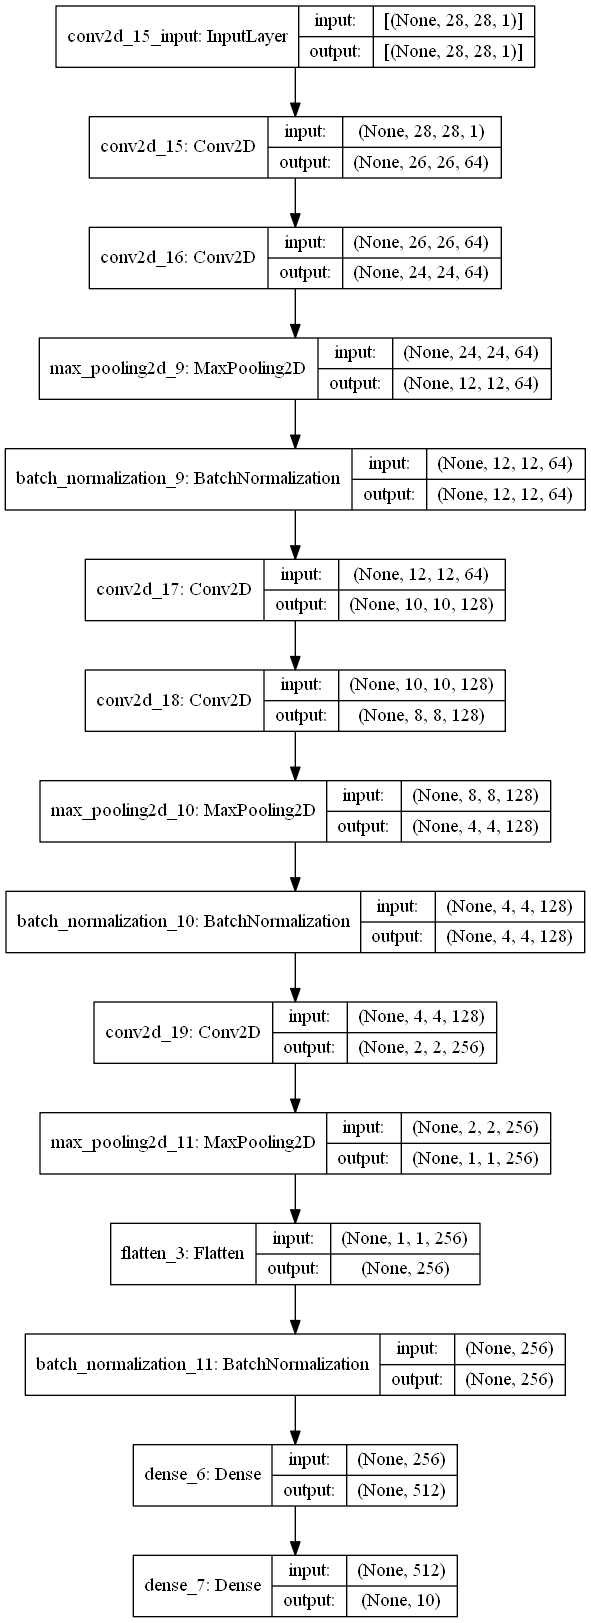

In [71]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True) #memplot model yang digunakan

## Evaluasi Model

### Kurva Training dan Validasi

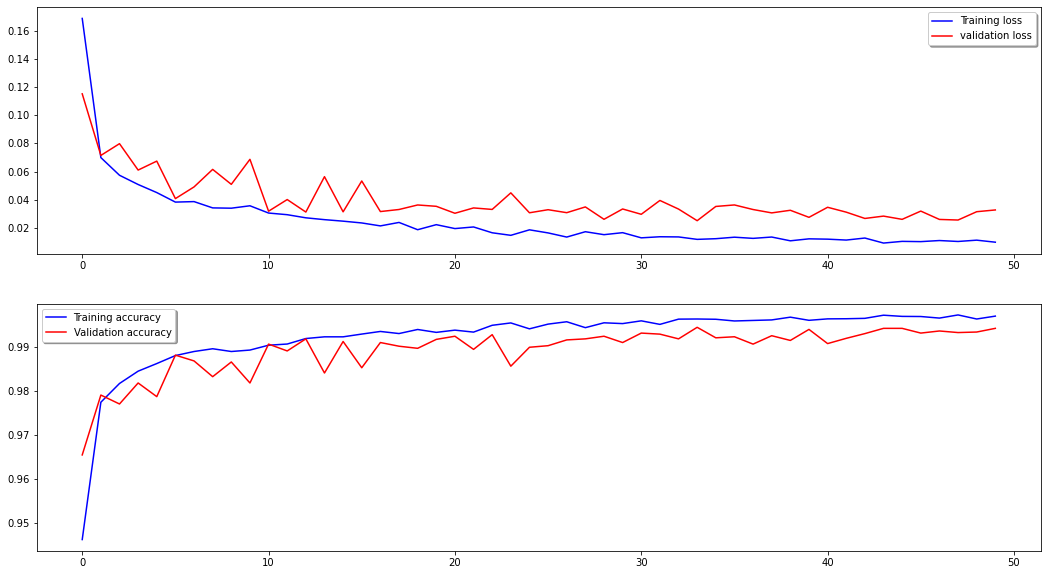

In [72]:
# Plot kurva loss dan accuracy untuk training dan validation 

fig, ax = plt.subplots(2,1, figsize=(18, 10)) # Set Figure
ax[0].plot(history.history['loss'], color='b', label="Training loss") #plot kurva untuk loss pada training
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0]) #plot kurva untuk loss pada validasi
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy") #plot kurva untuk akurasi pada training
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy") #plot kurva untuk akurasi pada validasi
legend = ax[1].legend(loc='best', shadow=True)

### Confusion Matrix

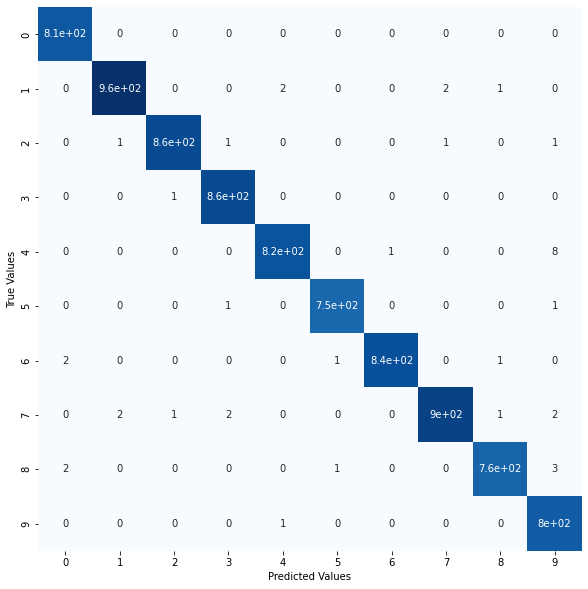

In [75]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict encoded label sebagai 2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values') #label untuk sumbu x yaitu predicted values
plt.ylabel('True Values'); #label untuk sumbu y yaitu true values
plt.show();

## Prediksi

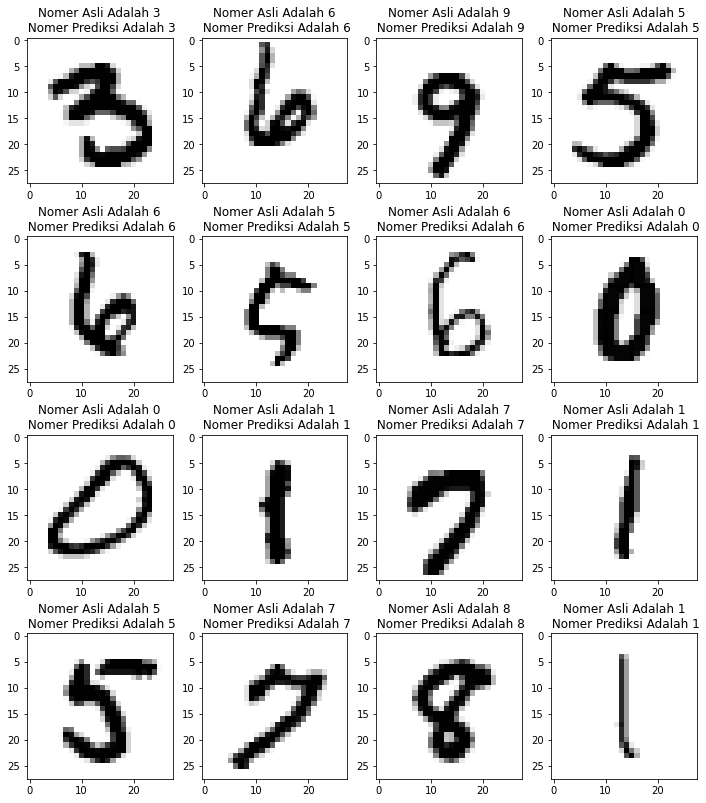

In [76]:
y_pred = model.predict(X_test) #melakukan prediksi 
X_test__ = X_test.reshape(X_test.shape[0], 28, 28) #mereshape x_test 

#menampilkan hasil prediksi
fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Nomer Asli Adalah {y_test[i].argmax()}\n Nomer Prediksi Adalah {y_pred[i].argmax()}");